**Import library**

In [0]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import time
# Standard plotly imports
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
# stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
from statsmodels.tsa.stattools import adfuller
#Prophet
from fbprophet import Prophet
# SKLEARN
from sklearn.metrics import mean_squared_error

**Import data**

In [0]:
# Read in the raw temperature dataset
raw_global = pd.read_csv('NH.Ts+dSST.csv', skiprows=1)
raw_global = raw_global.iloc[:,:13]

In [3]:
raw_global.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1880,-0.34,-0.50,-0.23,-0.29,-0.05,-0.15,-0.17,-0.25,-0.22,-0.30,-0.42,-.39
1,1881,-0.30,-0.21,-0.03,0.01,0.04,-0.32,0.09,-0.03,-0.25,-0.42,-0.35,-.22
2,1882,0.28,0.23,0.03,-0.30,-0.24,-0.28,-0.26,-0.13,-0.23,-0.51,-0.31,-.67
3,1883,-0.56,-0.64,-0.14,-0.29,-0.24,-0.10,-0.04,-0.21,-0.32,-0.15,-0.44,-.14
4,1884,-0.16,-0.11,-0.63,-0.59,-0.36,-0.40,-0.44,-0.49,-0.44,-0.43,-0.55,-.46


In [4]:
raw_global.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
135,2015,1.19,1.18,1.32,1.03,1.04,1.05,0.92,1.01,1.16,1.29,1.37,1.53
136,2016,1.55,1.93,1.91,1.49,1.11,1.12,1.04,1.11,1.22,1.03,1.11,1.03
137,2017,1.39,1.50,1.51,1.20,0.92,0.93,0.96,1.01,1.00,1.05,1.23,1.40
138,2018,1.14,1.23,1.18,0.97,1.01,0.86,0.90,0.86,0.96,1.23,0.98,1.09
139,2019,1.20,1.12,1.54,1.25,0.99,1.20,1.03,1.09,1.22,1.32,1.21,***


**Data Preprocessing**

In [0]:
def clean_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN

In [0]:
def preprocess_data(raw):
  data_horizon = pd.date_range(start='1/1/1880', end='12/31/2019', freq='M')
  data = pd.DataFrame(data_horizon, columns=['Date'])
  #extract temperature data
  temp_list = []
  for idx in range(raw.shape[0]):
    temp_list.extend(raw.iloc[idx,1:])
  data['Temp'] = temp_list
  #clean value
  data['Temp'] = data['Temp'].apply(lambda x: clean_value(x))
  data.fillna(method='ffill', inplace=True)
  return data

In [0]:
global_t = preprocess_data(raw_global)

In [8]:
global_t.head()

,Date,Temp
0,1880-01-31,-0.34
1,1880-02-29,-0.50
2,1880-03-31,-0.23
3,1880-04-30,-0.29
4,1880-05-31,-0.05


In [9]:
global_t.tail()

,Date,Temp
1675,2019-08-31,1.09
1676,2019-09-30,1.22
1677,2019-10-31,1.32
1678,2019-11-30,1.21
1679,2019-12-31,1.21


**Data Visualization**

In [10]:
fig = px.line(global_t, x="Date", y="Temp", title='Northern Hemisphere-mean monthly Combined Land-Surface Air and Sea-Surface Water Temperature Anomalies')
fig.show()

In [11]:
fig = px.line(global_t.resample('A', on='Date').mean().reset_index(), x="Date", y="Temp", title='Northern Hemisphere-mean yearly Combined Land-Surface Air and Sea-Surface Water Temperature Anomalies')
fig.show()

Test stationarity

In [0]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

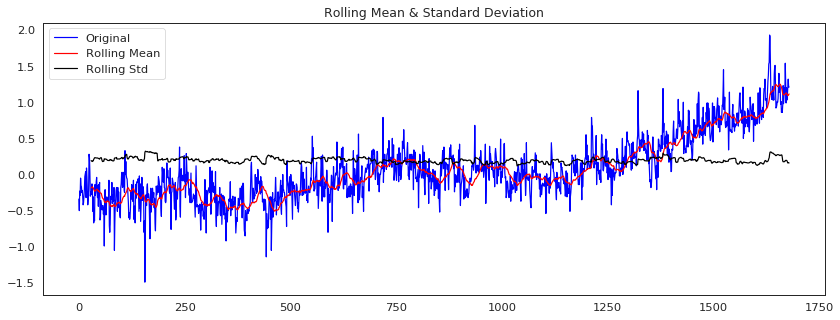

<Results of Dickey-Fuller Test>
Test Statistic                   -0.444751
p-value                           0.902355
#Lags Used                       24.000000
Number of Observations Used    1655.000000
Critical Value (1%)              -3.434307
Critical Value (5%)              -2.863288
Critical Value (10%)             -2.567701
dtype: float64


In [13]:
test_stationarity(global_t.Temp.dropna())

since the p-value > 0.05, we accept the null hypothesis (H0), the data has a unit root and is non-stationary.

**Time Series Prediction - SARIMA**

The Seasonal Autoregressive Integrated Moving Average (SARIMA) method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function and AR(P), I(D), MA(Q) and m parameters at the seasonal level, e.g. SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period). A SARIMA model can be used to develop AR, MA, ARMA and ARIMA models.

The method is suitable for univariate time series with trend and/or seasonal components.

In [0]:
def plot(y_true,y_pred):
    # Plot
    fig = go.Figure()
    x = global_t['Date'][global_t.shape[0]-len(y_true):]
    fig.add_trace(go.Scatter(x=x, y=y_true, mode='lines', name='actual'))
    fig.add_trace(go.Scatter(x=x, y=y_pred, mode='lines', name='predicted'))
    # Edit the layout
    fig.update_layout(title='Southern Hemisphere-mean Temperature: Predicted v.s. Actual',
                   xaxis_title='Month',
                   yaxis_title='Temperature')
    fig.show()

In [0]:
def SARIMA_prediction(temp_data):
  y_true = []
  y_pred = []
  temperature = temp_data['Temp'].tolist()
  train = temperature[:-336]
  test = temperature[len(train):]
  #predict the latest 336 values (20% of data)
  for idx in range(len(test)):
    true_val = test[idx]
    if len(y_pred)>0:
      record = train+y_pred
    else:
      record = train
    # fit model
    model = SARIMAX(record, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
    model_fit = model.fit(disp=False,low_memory=True)
    # make predictions 
    yhat = model_fit.predict(len(record), len(record))
    # save value
    y_true.append(true_val)
    y_pred.extend(yhat)
  print(mean_squared_error(y_true, y_pred))
  plot(y_true,y_pred)

In [64]:
start_time = time.time()
SARIMA_prediction(global_t)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



0.08250081848468503


In [65]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 264.31597328186035 seconds ---


**Time Series Prediction - Prophet**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [0]:
def prophet_prediction(temp_data):
  #removing the last 336 values (10 years)
  df = temp_data.iloc[:-336]
  df = df.rename(columns={'Date':'ds', 'Temp':'y'})
  #load prophet model
  model = Prophet(weekly_seasonality=True)
  model.fit(df)
  #prediction
  future = model.make_future_dataframe(periods=336, freq = 'm')
  forecast = model.predict(future)
  model.plot(forecast)
  return forecast

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


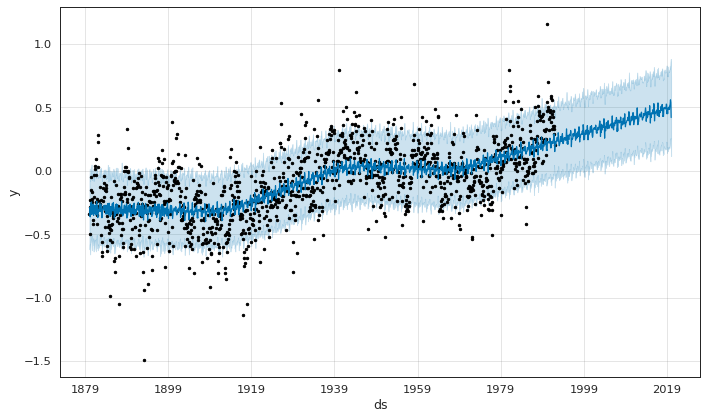

In [18]:
start_time = time.time()
prophet_forecast = prophet_prediction(global_t)

In [19]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.8717968463897705 seconds ---


In [0]:
prophet_forecast_last = prophet_forecast.iloc[prophet_forecast.shape[0]-336:]
global_t_last = global_t.iloc[global_t.shape[0]-336:]

In [21]:
mean_squared_error(global_t_last.Temp, prophet_forecast_last.yhat)

0.218618536983779

**Time series prediction - LSTM**

In [22]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)

Using TensorFlow backend.


**Data preparation**

In [0]:
temp_raw = np.array(global_t.Temp.astype("float32")).reshape(-1,1)
# Apply the MinMax scaler from sklearn to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
temp_LSTM = scaler.fit_transform(temp_raw)

In [24]:
# Train test split - Using 80% of data for training, 20% for validation.
ratio = 0.6
train_size = int(len(temp_LSTM) * ratio)
val_size = int(len(temp_LSTM) * 0.2)
test_size = len(temp_LSTM) - train_size - val_size
train, val, test = temp_LSTM[0:train_size, :], temp_LSTM[train_size:train_size+val_size, :], temp_LSTM[train_size+val_size:len(temp_LSTM), :]
print("Number of entries (training set, val set, test set): " + str((len(train), len(val), len(test))))

Number of entries (training set, val set, test set): (1008, 336, 336)


In [0]:
def create_dataset(dataset):
    window_size = 1
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [0]:
# Create test and training sets for one-step-ahead regression.
train_X, train_Y = create_dataset(train)
val_X, val_Y = create_dataset(val)
test_X, test_Y = create_dataset(test)

In [53]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1]))
val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1]))
print("Training data for Keras shape:")
print(train_X.shape)

Training data for Keras shape:
(1006, 1)


**LSTM Model**

The LSTM architecture here consists of:

- One input layer.
- One LSTM layer of 4 blocks.
- One Dense layer to produce a single output.
- Use MSE as loss function.

In [0]:
def LSTM_modelone(train_X, train_Y, window_size):
    model = Sequential()
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 10, 
              verbose = 2,
              validation_data=(val_X,val_Y),callbacks=[earlyStop])
    
    return model

In [29]:
start_time = time.time()
LSTM_model1 = LSTM_modelone(train_X, train_Y, window_size=1)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Train on 1006 samples, validate on 334 samples
Epoch 1/100


 - 6s - loss: 0.1418 - val_loss: 0.1265
Epoch 2/100
 - 1s - loss: 0.0515 - val_loss: 0.0452
Epoch 3/100
 - 1s - loss: 0.0142 - val_loss: 0.0145
Epoch 4/100
 - 1s - loss: 0.0064 - val_loss: 0.0083
Epoch 5/100
 - 1s - loss: 0.0058 - val_loss: 0.0074
Epoch 6/100
 - 1s - loss: 0.0057 - val_loss: 0.0070
Epoch 7/100
 - 1s - loss: 0.0056 - val_loss: 0.0068
Epoch 8/100
 - 1s - loss: 0.0056 - val_loss: 0.0071
Epoch 9/100
 - 1s - loss: 0.0055 - val_loss: 0.0068
Epoch 10/100
 - 1s - loss: 0.0054 - val_loss: 0.0067
Epoch 11/100
 - 1s - loss: 0.0053 - val_loss: 0.0063
Epoch 12/100
 - 1s - loss: 0.0052 - val_loss: 0.0063
Epoch 13/100
 - 1s - loss: 0.0052 - val_loss: 0.0062
Epoch 14/100
 - 1s - loss: 0.0051 - val_loss: 0.0059
Epoch 15/100
 - 1s - loss: 0.0050 - val_loss: 0.0053
Epoch 16/100
 - 1s - loss: 0.0049 - val_loss: 0.0057
Epoch 17/100
 - 1s - loss: 0.0048 - val_loss: 0.0054
Epoch 18/100
 - 1s - loss: 0.0047 - val_loss: 0.0052
Epoch 19/100
 - 1s - loss: 0.0046 - val_loss: 0.0052
Epoch 20/100
 

In [30]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 35.21963405609131 seconds ---


In [0]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = mean_squared_error(orig_data[0], pred[:, 0])
    return score

In [32]:
print("Test data score: %.3f MSE" % predict_and_score(LSTM_model1,test_X, test_Y))

Test data score: 0.088 MSE


The second model architecture is slightly more complex. Its elements are:

 - Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. The input shape will be 1 time step with 30 features.
 - Dropout 20%.
 - Use the MSE loss function and the efficient Adam version of stochastic gradient descent.
 - The model will be fit for 20 training epochs with a batch size of 70.

In [0]:
def LSTM_modeltwo(train_X, train_Y):
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  print(model.summary())

  model.fit(train_X, train_Y, epochs=50, batch_size=5, verbose=2, shuffle=False, validation_data=(val_X,val_Y),callbacks=[earlyStop])

  return model

In [44]:
start_time = time.time()
LSTM_model2 = LSTM_modeltwo(train_X, train_Y)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None
Train on 1006 samples, validate on 334 samples
Epoch 1/50
 - 3s - loss: 0.0233 - val_loss: 0.0035
Epoch 2/50
 - 1s - loss: 0.0047 - val_loss: 0.0034
Epoch 3/50
 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 4/50
 - 1s - loss: 0.0046 - val_loss: 0.0032
Epoch 5/50
 - 1s - loss: 0.0044 - val_loss: 0.0031
Epoch 6/50
 - 1s - loss: 0.0044 - val_loss: 0.0031
Epoch 7/50
 - 1s - los

In [45]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 35.40445637702942 seconds ---


In [46]:
print("Test data score: %.3f MSE" % predict_and_score(LSTM_model2,test_X, test_Y))

Test data score: 0.145 MSE


In [0]:
def predict_and_plot(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Plot
    fig = go.Figure()
    x = global_t['Date'][global_t.shape[0]-len(orig_data[0]):]
    fig.add_trace(go.Scatter(x=x, y=orig_data[0], mode='lines', name='actual'))
    fig.add_trace(go.Scatter(x=x, y=pred[:, 0], mode='lines', name='predicted'))
    # Edit the layout
    fig.update_layout(title='Northern Hemisphere-mean Temperature: Predicted v.s. Actual',
                   xaxis_title='Month',
                   yaxis_title='Temperature')
    fig.show()

In [50]:
predict_and_plot(LSTM_model1,test_X, test_Y)

**MLP Model**

In [0]:
def MLP_model(train_X, train_Y):
  model = Sequential()
  model.add(Dense(100,  input_shape=(1,)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Dense(50))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('linear'))
  model.compile(optimizer='adam', loss='mse')
  print(model.summary())
  model.fit(train_X, train_Y, epochs=50, batch_size=10, verbose=2, shuffle=False, validation_data=(val_X,val_Y),callbacks=[earlyStop])
  return model

In [55]:
start_time = time.time()
MLP_model_result = MLP_model(train_X, train_Y)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               200       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

In [56]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.789194107055664 seconds ---


In [57]:
print("Test data score: %.3f MSE" % predict_and_score(MLP_model_result,test_X, test_Y))

Test data score: 0.119 MSE
